### Import dependencies

In [1]:
import zipfile

In [3]:
# In case the path of your jupyter notebook is not set correctly, 
# uncomment and run with your project path:

# import os
# os.chdir('/home/sergiu/PycharmProjects/moc1-aset-project')

In order to download the raw competition data you can:
1. Use the kaggle api:  
    1. Consult https://github.com/Kaggle/kaggle-api/issues/15#issuecomment-374432095 to add the api keys. 
    2. pip install kaggle.
    3. kaggle competitions download -c freesound-audio-tagging-2019.
2. Call "wget https://www.kaggle.com/c/10700/download-all", but the download is limited to 1.8 MB/s.  

In [6]:
!pip install kaggle
!kaggle competitions download -c freesound-audio-tagging-2019
# !wget https://www.kaggle.com/c/10700/download-all

!mkdir data
!mv freesound-audio-tagging-2019.zip data/

  0%|                                      | 49.0M/24.4G [00:05<47:15, 9.21MB/s]^C
  0%|                                      | 50.0M/24.4G [00:06<53:53, 8.07MB/s]
User cancelled operation
mkdir: cannot create directory ‘data’: File exists


In [5]:
zip_path = 'data/freesound-audio-tagging-2019.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('data/')
    os.remove(zip_path)

FileNotFoundError: [Errno 2] No such file or directory: 'data/freesound-audio-tagging-2019.zip'

In [3]:
!ls data/

sample_submission.csv  train_curated	  train_noisy
test		       train_curated.csv  train_noisy.csv


In [1]:
zips = ['train_curated', 'train_noisy', 'test']
for zip_name in zips:
    zip_path = f'data/{zip_name}.zip'
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(f'data/{zip_name}/')
        os.remove(zip_path)

NameError: name 'zipfile' is not defined

The following code is from:  
https://www.kaggle.com/daisukelab/cnn-2d-basic-solution-powered-by-fast-ai?fbclid=IwAR35ItZNHdxy1SsAMrz_KLHoQP_DJhXbaf24K9_FQop9p9ggMb-iuPmiqNg

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import IPython
import IPython.display
import PIL

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("data"))

# Any results you write to the current directory are saved as output.

['test', 'sample_submission.csv', 'train_curated', 'train_noisy.csv', 'freesound-audio-tagging-2019.zip', 'train_noisy.zip', 'train_curated.csv']


File/folder definitions:
    - df will handle training data.
    - test_df will handle test data.

In [5]:
!python --version

Python 2.7.15+


In [5]:
DATA = Path('data')
CSV_TRN_CURATED = DATA/'train_curated.csv'
CSV_TRN_NOISY = DATA/'train_noisy.csv'
CSV_SUBMISSION = DATA/'sample_submission.csv'
TRN_CURATED = DATA/'train_curated'
TRN_NOISY = DATA/'train_noisy'
TEST = DATA/'test'

WORK = Path('work')
IMG_TRN_CURATED = WORK/'image/trn_curated'
IMG_TRN_NOISY = WORK/'image/train_noisy'
IMG_TEST = WORK/'image/test'
for folder in [WORK, IMG_TRN_CURATED, IMG_TRN_NOISY, IMG_TEST]: 
    Path(folder).mkdir(exist_ok=True, parents=True)

df = pd.read_csv(CSV_TRN_CURATED)
test_df = pd.read_csv(CSV_SUBMISSION)

In [6]:
!yes | conda install -c conda-forge librosa

/bin/sh: 1: conda: not found
yes: standard output: Broken pipe


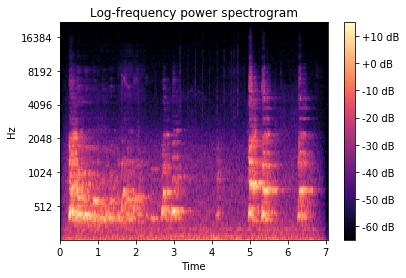

In [7]:
import librosa
import librosa.display

def read_audio(conf, pathname, trim_long_data):
    y, sr = librosa.load(pathname, sr=conf.sampling_rate)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > conf.samples: # long enough
        if trim_long_data:
            y = y[0:0+conf.samples]
    else: # pad blank
        padding = conf.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')
    return y

def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

def show_melspectrogram(conf, mels, title='Log-frequency power spectrogram'):
    librosa.display.specshow(mels, x_axis='time', y_axis='mel', 
                             sr=conf.sampling_rate, hop_length=conf.hop_length,
                            fmin=conf.fmin, fmax=conf.fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

def read_as_melspectrogram(conf, pathname, trim_long_data, debug_display=False):
    x = read_audio(conf, pathname, trim_long_data)
    mels = audio_to_melspectrogram(conf, x)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=conf.sampling_rate))
        show_melspectrogram(conf, mels)
    return mels


class conf:
    # Preprocessing settings
    sampling_rate = 44100
    duration = 2
    hop_length = 347*duration # to make time steps 128
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    samples = sampling_rate * duration

# example
x = read_as_melspectrogram(conf, TRN_CURATED/'0006ae4e.wav', trim_long_data=False, debug_display=True)

In [8]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    Xstd = (X - mean) / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Scale to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

def convert_wav_to_image(df, source, img_dest):
    X = []
    for i, row in tqdm_notebook(df.iterrows()):
        x = read_as_melspectrogram(conf, source/str(row.fname), trim_long_data=False)
        x_color = mono_to_color(x)
        X.append(x_color)
    return X

X_train = convert_wav_to_image(df, source=TRN_CURATED, img_dest=IMG_TRN_CURATED)
X_test = convert_wav_to_image(test_df, source=TEST, img_dest=IMG_TEST)

In [28]:
# !pip install http://download.pytorch.org/whl/cpu/torch-1.0.0-cp36-cp36m-linux_x86_64.whl
!yes | pip install torch torchvision
!yes | pip install fastai

     |████████████████████████████████| 773.1MB 75kB/s s eta 0:00:01   |██                              | 48.4MB 5.9MB/s eta 0:02:03     |████████▋                       | 209.1MB 2.5MB/s eta 0:03:50     |███████████████▊                | 378.8MB 7.1MB/s eta 0:00:56
     |████████████████████████████████| 10.2MB 3.9MB/s eta 0:00:01
yes: standard output: Broken pipe
  Using cached https://files.pythonhosted.org/packages/b9/88/386289f6926a59cbd2765b033f5fe8414d6ff89ab27044dffe740cc1a5f3/fastai-1.0.58-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/83/db/794db47024a26c75635c35f0ee5431aa8b528e895ad1ed958041290f83f7/fastprogress-0.1.21-py3-none-any.whl
     |████████████████████████████████| 10.2MB 15.2MB/s eta 0:00:01
     |████████████████████████████████| 2.1MB 5.0MB/s eta 0:00:01
     |████████████████████████████████| 122kB 9.8MB/s eta 0:00:01
     |████████████████████████████████| 3.7MB 3.0MB/s eta 0:00:01
     |████████████████████████████████| 184kB 3.3MB/s 

In [29]:
from fastai import *
from fastai.vision import *
from fastai.vision.data import *
import random

CUR_X_FILES, CUR_X = list(df.fname.values), X_train

def open_fat2019_image(fn, convert_mode, after_open)->Image:
    # open
    idx = CUR_X_FILES.index(fn.split('/')[-1])
    x = PIL.Image.fromarray(CUR_X[idx])
    # crop
    time_dim, base_dim = x.size
    crop_x = random.randint(0, time_dim - base_dim)
    x = x.crop([crop_x, 0, crop_x+base_dim, base_dim])    
    # standardize
    return Image(pil2tensor(x, np.float32).div_(255))

vision.data.open_image = open_fat2019_image

In [30]:
# from official code https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8#scrollTo=cRCaCIb9oguU
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class


# Wrapper for fast.ai library
def lwlrap(scores, truth, **kwargs):
    score, weight = calculate_per_class_lwlrap(to_np(truth), to_np(scores))
    return torch.Tensor([(score * weight).sum()])

In [31]:
tfms = get_transforms(do_flip=True, max_rotate=0, max_lighting=0.1, max_zoom=0, max_warp=0.)
src = (ImageList.from_csv(WORK/'image', Path('../../')/CSV_TRN_CURATED, folder='trn_curated')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=',')
)
data = (src.transform(tfms, size=128)
        .databunch(bs=64).normalize(imagenet_stats)
)

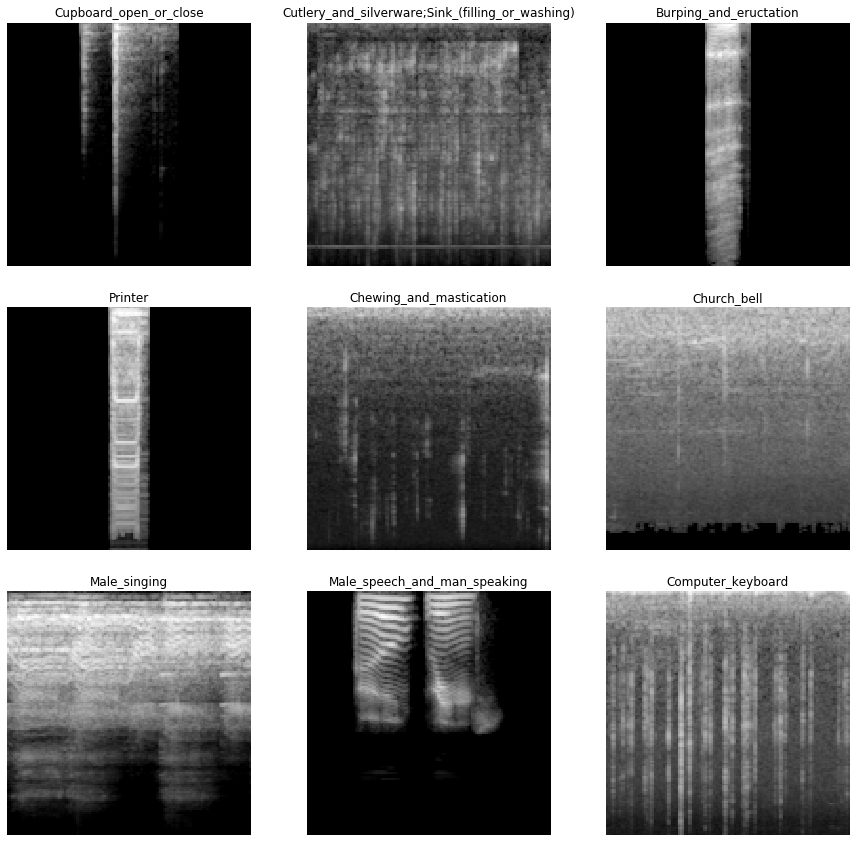

In [32]:
data.show_batch(3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


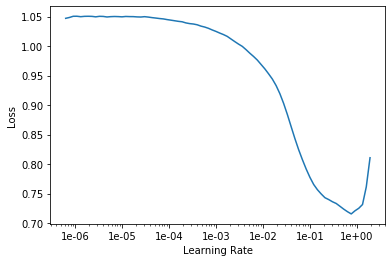

In [33]:
learn = cnn_learner(data, models.resnet18, pretrained=False, metrics=[lwlrap])
learn.unfreeze()

learn.lr_find(); learn.recorder.plot()

In [34]:
learn.fit_one_cycle(5, 1e-1)
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,lwlrap,time
0,0.253365,10.508744,0.073768,00:19
1,0.126459,0.087096,0.158948,00:18
2,0.094260,0.071768,0.144457,00:19
3,0.079753,0.069508,0.177522,00:19
4,0.071608,0.065158,0.279564,00:20


epoch,train_loss,valid_loss,lwlrap,time
0,0.066821,0.065424,0.272221,00:20
1,0.066868,0.082558,0.263298,00:20
2,0.066390,0.063814,0.268101,00:20
3,0.066049,0.071261,0.218720,00:20
4,0.065612,0.061124,0.322135,00:20
5,0.063364,0.058401,0.365536,00:20
6,0.061428,0.056682,0.386982,00:20
7,0.059316,0.054776,0.412194,00:20
8,0.057681,0.060434,0.450886,00:20
9,0.056332,0.069290,0.450394,00:20


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


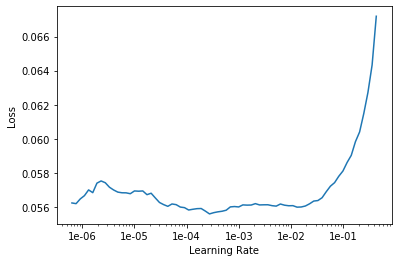

In [35]:
learn.lr_find(); learn.recorder.plot()

In [36]:
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,lwlrap,time
0,0.055914,0.053901,0.454123,00:20
1,0.055990,0.083422,0.371800,00:20
2,0.056058,0.051765,0.463498,00:20
3,0.055990,0.054002,0.424937,00:20
4,0.055381,0.056754,0.362277,00:20
5,0.055041,0.056947,0.366267,00:20
6,0.054221,0.055373,0.410359,00:20
7,0.053002,0.051623,0.459336,00:21
8,0.051847,0.049294,0.496415,00:21
9,0.051740,0.053587,0.513383,00:21


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


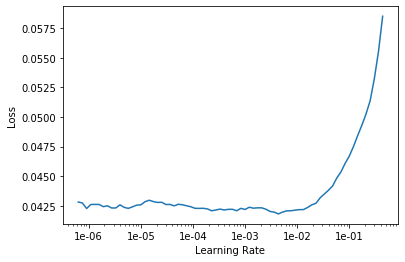

In [37]:
learn.lr_find(); learn.recorder.plot()

In [38]:
learn.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,lwlrap,time
0,0.041786,0.180361,0.616110,00:20
1,0.041594,0.069728,0.610715,00:21
2,0.041842,0.121087,0.616918,00:21
3,0.041458,0.313276,0.614032,00:21
4,0.041843,0.434580,0.615042,00:21
5,0.041723,0.041523,0.597624,00:21
6,0.041340,0.886137,0.619063,00:21
7,0.040422,0.038873,0.644292,00:21
8,0.039994,1.030554,0.627621,00:21
9,0.039220,0.040168,0.629423,00:21


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


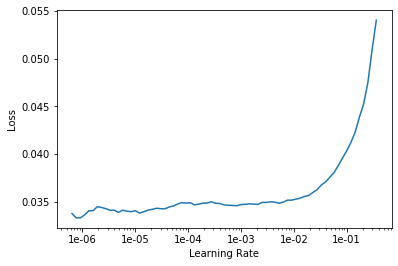

In [39]:
learn.lr_find(); learn.recorder.plot()

In [40]:
learn.fit_one_cycle(50, slice(1e-3, 3e-3))

epoch,train_loss,valid_loss,lwlrap,time
0,0.034862,0.998461,0.668494,00:21
1,0.034748,2.117391,0.666883,00:21
2,0.034997,0.598721,0.676003,00:21
3,0.034424,4.894077,0.664395,00:21
4,0.034614,3.690018,0.656919,00:21
5,0.034467,0.285228,0.664487,00:21
6,0.034341,3.900191,0.651939,00:21
7,0.034411,1.630569,0.655707,00:21
8,0.034470,2.692971,0.662467,00:21
9,0.034316,3.669663,0.658245,00:21


In [41]:
learn.fit_one_cycle(10, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,lwlrap,time
0,0.015492,1.934996,0.724380,00:21
1,0.015538,1.847237,0.724508,00:21
2,0.015691,0.036653,0.714979,00:21
3,0.015736,0.038519,0.721960,00:21
4,0.015777,0.043633,0.715043,00:21
5,0.015630,0.041479,0.732848,00:21
6,0.015206,0.305221,0.722261,00:21
7,0.014949,0.109374,0.727068,00:21
8,0.014536,0.042724,0.722644,00:21
9,0.014556,0.036570,0.730116,00:21


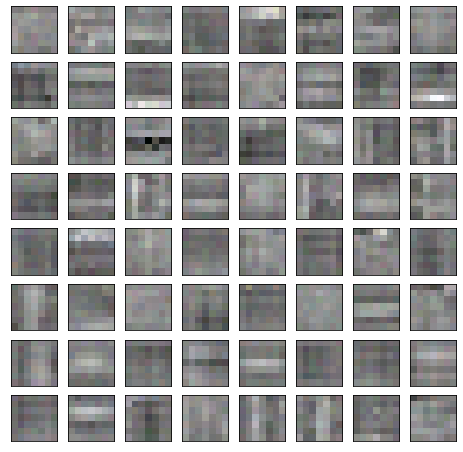

In [42]:
# https://discuss.pytorch.org/t/how-to-visualize-the-actual-convolution-filters-in-cnn/13850
from sklearn.preprocessing import minmax_scale

def visualize_first_layer(learn, save_name=None):
    conv1 = list(learn.model.children())[0][0]
    if isinstance(conv1, torch.nn.modules.container.Sequential):
        conv1 = conv1[0] # for some models, 1 layer inside
    weights = conv1.weight.data.cpu().numpy()
    weights_shape = weights.shape
    weights = minmax_scale(weights.ravel()).reshape(weights_shape)
    fig, axes = plt.subplots(8, 8, figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.rollaxis(weights[i], 0, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    if save_name:
        fig.savefig(str(save_name))

visualize_first_layer(learn)

In [43]:
learn.save('fat2019_fastai_cnn2d_stage-2')
learn.export()

/home/sergiu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BCEWithLogitsLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/sergiu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/sergiu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/sergiu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.

In [44]:
CUR_X_FILES, CUR_X = list(test_df.fname.values), X_test

test = ImageList.from_csv(WORK/'image', Path('../..')/CSV_SUBMISSION, folder='test')
learn = load_learner(WORK/'image', test=test)
preds, _ = learn.TTA(ds_type=DatasetType.Test) # <== Simply replacing from learn.get_preds()

/home/sergiu/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/home/sergiu/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/home/sergiu/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/home/sergiu/anaconda3/lib/python3.7/site-p

/home/sergiu/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/home/sergiu/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/home/sergiu/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/home/sergiu/anaconda3/lib/python3.7/site-p

/home/sergiu/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/home/sergiu/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/home/sergiu/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/home/sergiu/anaconda3/lib/python3.7/site-p

In [45]:
test_df[learn.data.classes] = preds
test_df.to_csv('submission.csv', index=False)
test_df.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,4260ebea.wav,0.000118,6.523908e-07,9.793999e-05,2.226585e-06,0.004426,1.801292e-03,2.884709e-05,0.003979,1.179982e-04,...,0.001075,4.285716e-05,0.007399,0.001154,0.069049,0.000046,0.000060,0.047008,0.000018,0.001857
1,426eb1e0.wav,0.000009,7.643160e-08,1.810385e-08,3.853152e-01,0.000016,7.633720e-05,3.239311e-06,0.010727,2.130968e-06,...,0.000323,1.428327e-04,0.013320,0.014768,0.000020,0.004421,0.000003,0.004416,0.000013,0.008133
2,428d70bb.wav,0.002378,9.783694e-06,3.119825e-05,5.953363e-05,0.001087,1.134679e-04,1.656504e-05,0.000166,1.278436e-03,...,0.003927,3.221251e-02,0.000265,0.001453,0.000156,0.011028,0.030034,0.000234,0.000181,0.003910
3,4292b1c9.wav,0.000007,3.927019e-10,5.285012e-08,1.720714e-08,0.000084,3.564584e-09,7.446466e-09,0.000009,2.557516e-09,...,0.000004,7.492711e-07,0.000004,0.000061,0.000003,0.000114,0.000061,0.029764,0.000005,0.041983
4,429c5071.wav,0.012766,1.380486e-05,1.353342e-04,4.633318e-05,0.001139,2.424482e-02,1.302411e-03,0.001080,9.333907e-04,...,0.002291,9.287182e-04,0.002923,0.110993,0.001951,0.005391,0.000307,0.002306,0.000047,0.025611


In [46]:
CUR_X_FILES, CUR_X = list(df.fname.values), X_train
learn = cnn_learner(data, models.resnet18, pretrained=False, metrics=[lwlrap])
learn.load('fat2019_fastai_cnn2d_stage-2');

In [47]:
CUR_X_FILES, CUR_X = list(df.fname.values), X_train
learn = cnn_learner(data, models.resnet18, pretrained=False, metrics=[lwlrap])
learn.load('fat2019_fastai_cnn2d_stage-2');

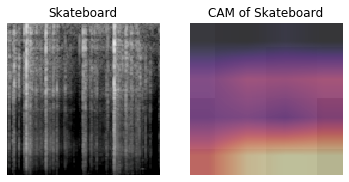

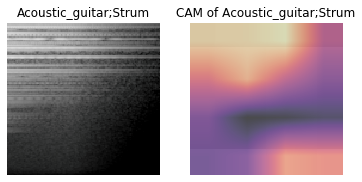

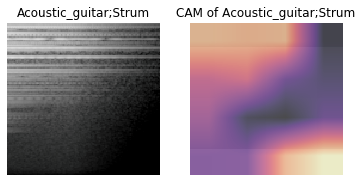

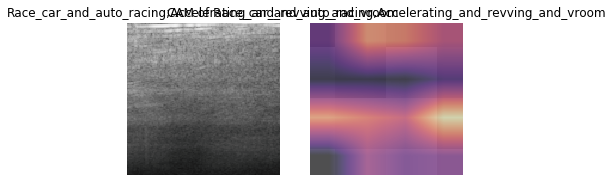

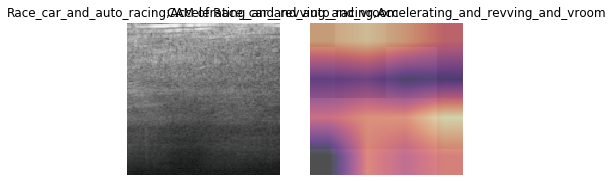

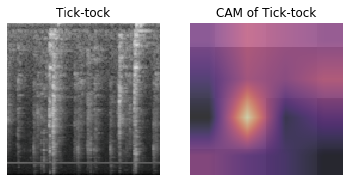

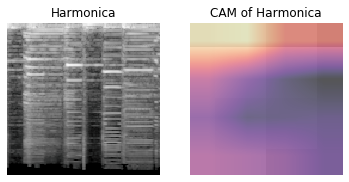

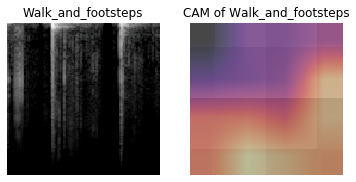

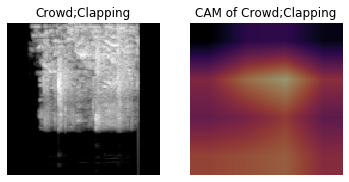

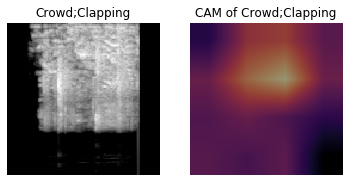

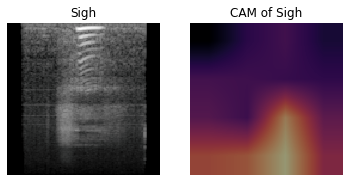

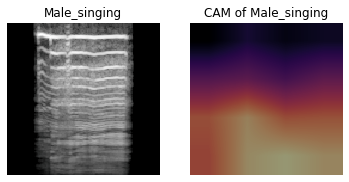

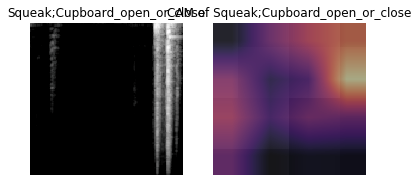

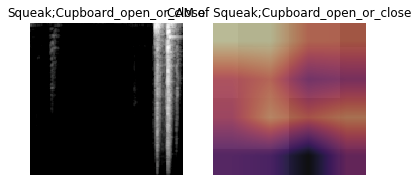

In [48]:
# Thanks to https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson6-pets-more.ipynb
from fastai.callbacks.hooks import *

def visualize_cnn_by_cam(learn, data_index):
    x, _y = learn.data.valid_ds[data_index]
    y = _y.data
    if not isinstance(y, (list, np.ndarray)): # single label -> one hot encoding
        y = np.eye(learn.data.valid_ds.c)[y]

    m = learn.model.eval()
    xb,_ = learn.data.one_item(x)
    xb_im = Image(learn.data.denorm(xb)[0])
    xb = xb.cuda()

    def hooked_backward(cat):
        with hook_output(m[0]) as hook_a: 
            with hook_output(m[0], grad=True) as hook_g:
                preds = m(xb)
                preds[0,int(cat)].backward()
        return hook_a,hook_g
    def show_heatmap(img, hm, label):
        _,axs = plt.subplots(1, 2)
        axs[0].set_title(label)
        img.show(axs[0])
        axs[1].set_title(f'CAM of {label}')
        img.show(axs[1])
        axs[1].imshow(hm, alpha=0.6, extent=(0,img.shape[0],img.shape[0],0),
                      interpolation='bilinear', cmap='magma');
        plt.show()

    for y_i in np.where(y > 0)[0]:
        hook_a,hook_g = hooked_backward(cat=y_i)
        acts = hook_a.stored[0].cpu()
        grad = hook_g.stored[0][0].cpu()
        grad_chan = grad.mean(1).mean(1)
        mult = (acts*grad_chan[...,None,None]).mean(0)
        show_heatmap(img=xb_im, hm=mult, label=str(learn.data.valid_ds.y[data_index]))

for idx in range(10):
    visualize_cnn_by_cam(learn, idx)